# Fit BAO peak from input correlation function

In [2]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [3]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [4]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [5]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [6]:
ells = [0]
nells = len(ells)

### Density split

In [7]:
nsplits = 2
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_dg_CCFs_cellsize10.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_dg_CCF_cellsize10.npy', allow_pickle=True)

In [7]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)

split = 1
abacus_result = abacus_split_results[split]
s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)
cov = extract_subcovmatrix(s, split_cov, ells, nsplits, split_extract=split)
cov /= 8.
std = np.array_split(np.array(np.array_split(np.diag(cov)**0.5, nells)), nsplits, axis=1)

### 2PCF

In [8]:
#abacus_result = TwoPointCorrelationFunction.load(output_dir+catalog.name+'_2PCF.npy')
#mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_2PCF.npy', allow_pickle=True)

#_, cov = get_poles(mocks_results, ells)
#cov /= 8.
#std = np.array_split(np.diag(cov)**0.5, nells)

#s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)

## Set power spectrum model

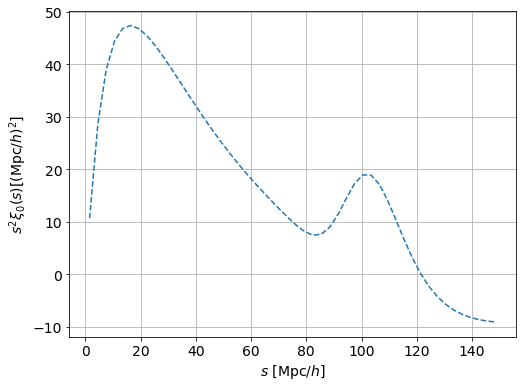

In [9]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': 0., 'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 0.}
pk_model.set_default_params(**default_params)
pk_model.plot_model()

## Fit model to data

In [10]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 1., 'alpha_par': 1., 'sigma_par': 6., 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit, negative=False)

Optimal parameters:
{'b': 2.586575595049697, 'alpha_par': 1.0081077568397985, 'sigma_par': 6.6923708405326625, 'broadband_coeffs': array([ 2.12244151e+01, -4.17595784e-01,  1.97070578e-03])}

Covariance matrix:
[[ 1.35074097e-02  1.96702914e-04  4.82635894e-02 -9.85144011e-01
   1.25655446e-02 -3.48727653e-05]
 [ 1.96702914e-04  1.46652031e-04  1.05032451e-03 -3.93140289e-03
   1.24349392e-04 -5.40881674e-07]
 [ 4.82635894e-02  1.05032451e-03  2.83222585e-01 -3.37431411e+00
   4.15486975e-02 -1.03933789e-04]
 [-9.85144011e-01 -3.93140289e-03 -3.37431411e+00  1.04686614e+02
  -1.76201376e+00  6.90868751e-03]
 [ 1.25655446e-02  1.24349392e-04  4.15486975e-02 -1.76201376e+00
   3.59289016e-02 -1.64231612e-04]
 [-3.48727653e-05 -5.40881674e-07 -1.03933789e-04  6.90868751e-03
  -1.64231612e-04  8.49307667e-07]]

Sigmas:
[1.16221382e-01 1.21099972e-02 5.32186607e-01 1.02316477e+01
 1.89549206e-01 9.21578899e-04]


({'b': 2.586575595049697,
  'alpha_par': 1.0081077568397985,
  'sigma_par': 6.6923708405326625,
  'broadband_coeffs': array([ 2.12244151e+01, -4.17595784e-01,  1.97070578e-03])},
 array([[ 1.35074097e-02,  1.96702914e-04,  4.82635894e-02,
         -9.85144011e-01,  1.25655446e-02, -3.48727653e-05],
        [ 1.96702914e-04,  1.46652031e-04,  1.05032451e-03,
         -3.93140289e-03,  1.24349392e-04, -5.40881674e-07],
        [ 4.82635894e-02,  1.05032451e-03,  2.83222585e-01,
         -3.37431411e+00,  4.15486975e-02, -1.03933789e-04],
        [-9.85144011e-01, -3.93140289e-03, -3.37431411e+00,
          1.04686614e+02, -1.76201376e+00,  6.90868751e-03],
        [ 1.25655446e-02,  1.24349392e-04,  4.15486975e-02,
         -1.76201376e+00,  3.59289016e-02, -1.64231612e-04],
        [-3.48727653e-05, -5.40881674e-07, -1.03933789e-04,
          6.90868751e-03, -1.64231612e-04,  8.49307667e-07]]))

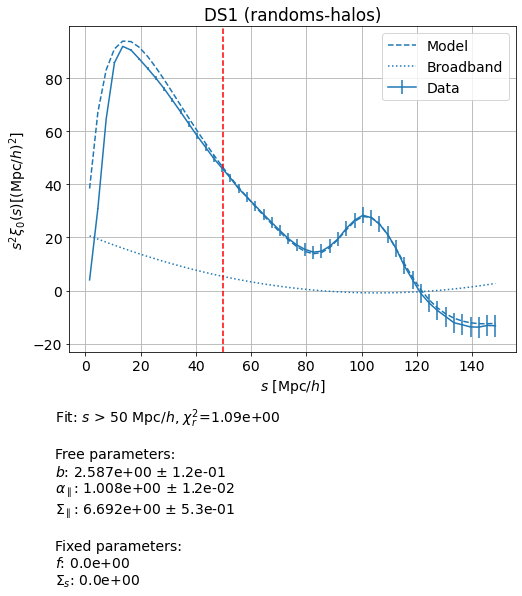

In [11]:
pk_model.plot_model(plot_data=True, show_info=True, show_broadband=True)
plt.title('DS1 (randoms-halos)')
plt.show()

### Plot reduced $\chi^2$ as a function of a given parameter ($\alpha_{iso}$ or $\Sigma_{iso}$)

In [14]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

{'b': 2.661445266339616, 'sigma_par': 7.136212505557423, 'broadband_coeffs': array([ 6.70684855e+01, -1.09602329e+00,  4.35143257e-03])}
{'b': 2.6666410841420203, 'sigma_par': 7.136337249193255, 'broadband_coeffs': array([ 6.67967536e+01, -1.08965116e+00,  4.32254000e-03])}
{'b': 2.671838543420185, 'sigma_par': 7.138245373127157, 'broadband_coeffs': array([ 6.65244316e+01, -1.08325847e+00,  4.29360155e-03])}
{'b': 2.6770403572463994, 'sigma_par': 7.141935451094083, 'broadband_coeffs': array([ 6.62514446e+01, -1.07684670e+00,  4.26463180e-03])}
{'b': 2.6822435548940864, 'sigma_par': 7.147372643489232, 'broadband_coeffs': array([ 6.59780121e+01, -1.07041791e+00,  4.23563165e-03])}
{'b': 2.6874484619169623, 'sigma_par': 7.1545479733186195, 'broadband_coeffs': array([ 6.57043048e+01, -1.06397724e+00,  4.20662850e-03])}
{'b': 2.6926546457207072, 'sigma_par': 7.163440678999369, 'broadband_coeffs': array([ 6.54304830e+01, -1.05752844e+00,  4.17763935e-03])}
{'b': 2.6978620186615707, 'sigma_pa

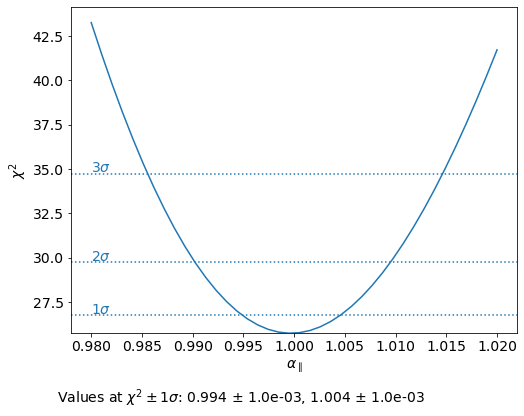

In [15]:
alphas = np.linspace(0.98, 1.02, 40)
free_params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

In [46]:
nparams = 6
conf_int = [scipy.stats.chi2.cdf(s**2, 1) for s in [1, 2, 3]]
chi2_sigmas = [scipy.stats.chi2.ppf(ci, nparams) for ci in conf_int]
print(chi2_sigmas)

[7.038400923736641, 12.848834791793387, 20.06208616571403]


In [47]:
conf_int

[0.6826894921370859, 0.9544997361036415, 0.9973002039367398]

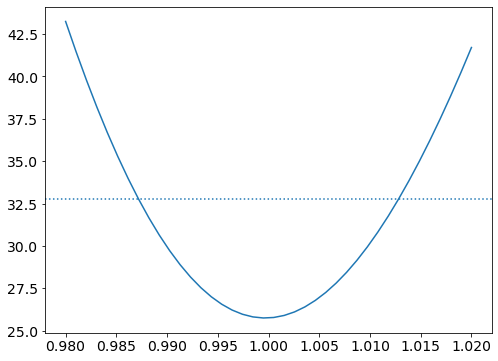

In [48]:
plt.plot(alphas, alpha_chi2_bao_peak)
chi2min = np.min(alpha_chi2_bao_peak)
plt.axhline(chi2min+chi2_sigmas[0], linestyle='dotted')

In [49]:
param_limits_idx = np.argwhere(np.diff(np.sign(alpha_chi2_bao_peak - (chi2min+chi2_sigmas[0])))).flatten()

In [50]:
test = np.array([alphas[i] for i in param_limits_idx])

In [51]:
np.diff(test)/2

array([0.01333333])

/feynman/work/dphp/adematti/cosmodesiconda/20220419-1.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


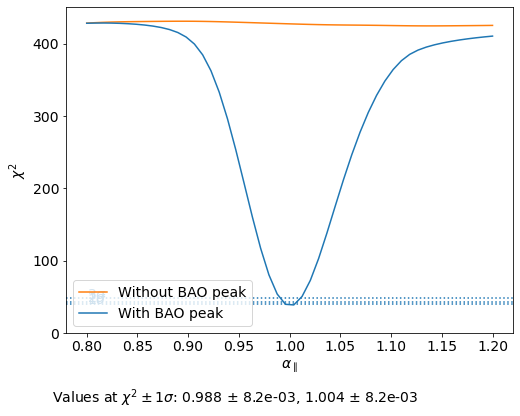

In [14]:
alphas = np.linspace(0.8, 1.2, 50)

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)

In [15]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

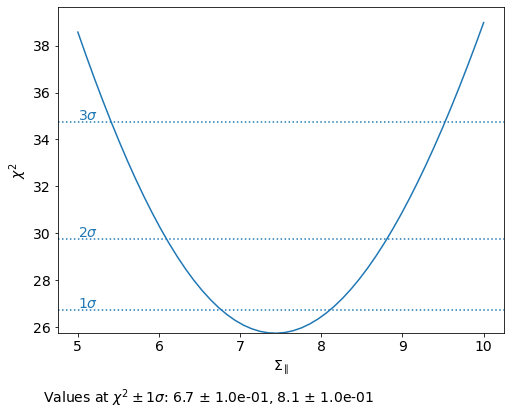

In [17]:
sigmas = np.linspace(5, 10, 50)
free_params_init = {'b': 2., 'alpha_par': 1., 'broadband_coeffs': broadband_coeffs}

sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

In [ ]:
sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)